In [2]:
# Import the required libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
import librosa
import numpy as np
import os

# Define the emotion mapping from the dataset
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Function to load data from the nested subfolders
def load_data(data_dir):
    features = []
    labels = []
    
    # Loop through each actor folder
    for actor_dir in os.listdir(data_dir):
        actor_path = os.path.join(data_dir, actor_dir)
        
        # Ensure the directory is indeed an actor folder
        if os.path.isdir(actor_path):
            # Loop through all the wav files inside each actor folder
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    # Extract the emotion code from the filename
                    emotion = file.split("-")[2]
                    if emotion in emotion_dict:
                        label = emotion_dict[emotion]
                        
                        # Load the audio file
                        file_path = os.path.join(actor_path, file)
                        signal, sample_rate = librosa.load(file_path)
                        
                        # Extract features
                        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
                        chroma = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
                        mel = librosa.feature.melspectrogram(y=signal, sr=sample_rate)
                        contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
                        tonnetz = librosa.feature.tonnetz(y=signal, sr=sample_rate)

                        # Concatenate and flatten the features
                        feature = np.hstack((
                            np.mean(mfccs, axis=1),
                            np.mean(chroma, axis=1),
                            np.mean(mel, axis=1),
                            np.mean(contrast, axis=1),
                            np.mean(tonnetz, axis=1)
                        ))
                        
                        # Append features and labels
                        features.append(feature)
                        labels.append(label)
    
    return np.array(features), np.array(labels)

# Provide the directory where your RAVDESS dataset is stored
data_dir = 'speech-emotion-recognition-ravdess-data'
X, y = load_data(data_dir)


C:\Users\HI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


In [7]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
# Build the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=42)

# Train the model
mlp.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = mlp.predict(X_test_scaled)

# Print performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.67      0.68        42
        calm       0.60      0.59      0.60        44
     disgust       0.48      0.69      0.56        32
     fearful       0.59      0.53      0.56        32
       happy       0.53      0.59      0.56        34
     neutral       0.44      0.40      0.42        20
         sad       0.49      0.44      0.46        39
   surprised       0.67      0.58      0.62        45

    accuracy                           0.57       288
   macro avg       0.56      0.56      0.56       288
weighted avg       0.58      0.57      0.57       288

Confusion Matrix:
[[28  0  8  3  2  0  0  1]
 [ 0 26  5  1  0  2  9  1]
 [ 0  1 22  1  5  0  0  3]
 [ 2  1  3 17  3  1  3  2]
 [ 2  0  4  2 20  0  2  4]
 [ 1  7  0  0  1  8  3  0]
 [ 4  8  1  0  1  6 17  2]
 [ 3  0  3  5  6  1  1 26]]


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128, 64), (128, 128), (256, 128)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300, 500]
}

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(mlp, param_grid, n_iter=10, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Use the best estimator
best_mlp = random_search.best_estimator_

# Predict with the best model
y_pred_best = best_mlp.predict(X_test_scaled)

# Print the updated classification report
print("Classification Report after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))


C:\Users\HI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HI\AppData\Local

Classification Report after Hyperparameter Tuning:
              precision    recall  f1-score   support

       angry       0.78      0.69      0.73        42
        calm       0.67      0.70      0.69        44
     disgust       0.47      0.59      0.53        32
     fearful       0.56      0.47      0.51        32
       happy       0.41      0.47      0.44        34
     neutral       0.50      0.55      0.52        20
         sad       0.51      0.46      0.49        39
   surprised       0.67      0.62      0.64        45

    accuracy                           0.58       288
   macro avg       0.57      0.57      0.57       288
weighted avg       0.59      0.58      0.58       288



             Base Model                     Fine-Tuned Model            \
              precision    recall  f1-score        precision    recall   
angry          0.606061  0.476190  0.533333         0.783784  0.690476   
calm           0.508772  0.659091  0.574257         0.673913  0.704545   
disgust        0.437500  0.437500  0.437500         0.475000  0.593750   
fearful        0.517241  0.468750  0.491803         0.555556  0.468750   
happy          0.416667  0.441176  0.428571         0.410256  0.470588   
neutral        0.375000  0.150000  0.214286         0.500000  0.550000   
sad            0.394737  0.384615  0.389610         0.514286  0.461538   
surprised      0.545455  0.666667  0.600000         0.666667  0.622222   
accuracy       0.489583  0.489583  0.489583         0.579861  0.579861   
macro avg      0.475179  0.460499  0.458670         0.572433  0.570234   
weighted avg   0.486108  0.489583  0.480753         0.588732  0.579861   

                        
            

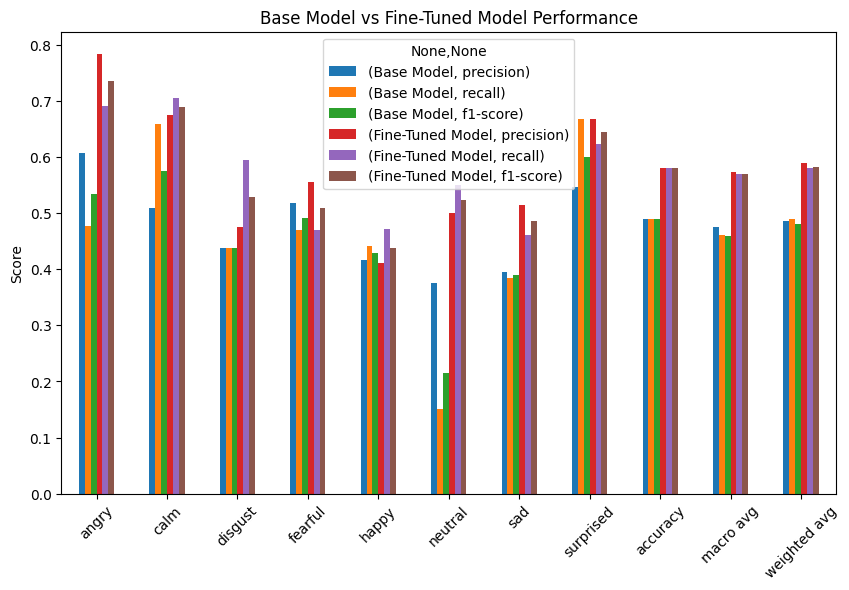

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the classification reports as dataframes
report_base = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_fine_tuned = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_, output_dict=True)

# Convert to pandas dataframe for comparison
df_base = pd.DataFrame(report_base).transpose()
df_fine_tuned = pd.DataFrame(report_fine_tuned).transpose()

# Concatenate for easy comparison
df_comparison = pd.concat([df_base[['precision', 'recall', 'f1-score']], df_fine_tuned[['precision', 'recall', 'f1-score']]], axis=1, keys=['Base Model', 'Fine-Tuned Model'])

# Show the comparison
print(df_comparison)

# Visualize the results
df_comparison.plot(kind='bar', figsize=(10,6))
plt.title('Base Model vs Fine-Tuned Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


In [17]:
from sklearn.model_selection import cross_val_score

# Define base model
base_mlp_cv = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, activation='relu', solver='adam', random_state=42)

# Perform K-fold cross-validation with k=5
cv_scores = cross_val_score(base_mlp_cv, X_train_scaled, y_train, cv=5)

# Print K-fold cross-validation results
print(f"K-Fold Cross Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")


K-Fold Cross Validation Scores: [0.57575758 0.57575758 0.55652174 0.55217391 0.55217391]
Mean Accuracy: 0.5624769433465087


In [18]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm = SVC(kernel='linear')

# Train the SVM model
svm.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_svm = svm.predict(X_test_scaled)

# Print classification report for SVM
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))


Classification Report (SVM):
              precision    recall  f1-score   support

       angry       0.51      0.55      0.53        42
        calm       0.60      0.64      0.62        44
     disgust       0.36      0.59      0.45        32
     fearful       0.28      0.22      0.25        32
       happy       0.31      0.32      0.31        34
     neutral       0.37      0.35      0.36        20
         sad       0.46      0.31      0.37        39
   surprised       0.57      0.47      0.51        45

    accuracy                           0.44       288
   macro avg       0.43      0.43      0.42       288
weighted avg       0.45      0.44      0.44       288



In [19]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with k=5 (can try other values)
knn = KNeighborsClassifier(n_neighbors=5)

# Train the KNN model
knn.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_knn = knn.predict(X_test_scaled)

# Print classification report for KNN
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))


Classification Report (KNN):
              precision    recall  f1-score   support

       angry       0.58      0.69      0.63        42
        calm       0.61      0.64      0.62        44
     disgust       0.36      0.66      0.47        32
     fearful       0.37      0.31      0.34        32
       happy       0.28      0.21      0.24        34
     neutral       0.32      0.45      0.38        20
         sad       0.46      0.28      0.35        39
   surprised       0.73      0.49      0.59        45

    accuracy                           0.48       288
   macro avg       0.46      0.47      0.45       288
weighted avg       0.49      0.48      0.47       288



              Base MLP                     Fine-Tuned MLP                      \
             precision    recall  f1-score      precision    recall  f1-score   
angry         0.606061  0.476190  0.533333       0.783784  0.690476  0.734177   
calm          0.508772  0.659091  0.574257       0.673913  0.704545  0.688889   
disgust       0.437500  0.437500  0.437500       0.475000  0.593750  0.527778   
fearful       0.517241  0.468750  0.491803       0.555556  0.468750  0.508475   
happy         0.416667  0.441176  0.428571       0.410256  0.470588  0.438356   
neutral       0.375000  0.150000  0.214286       0.500000  0.550000  0.523810   
sad           0.394737  0.384615  0.389610       0.514286  0.461538  0.486486   
surprised     0.545455  0.666667  0.600000       0.666667  0.622222  0.643678   
accuracy      0.489583  0.489583  0.489583       0.579861  0.579861  0.579861   
macro avg     0.475179  0.460499  0.458670       0.572433  0.570234  0.568956   
weighted avg  0.486108  0.48

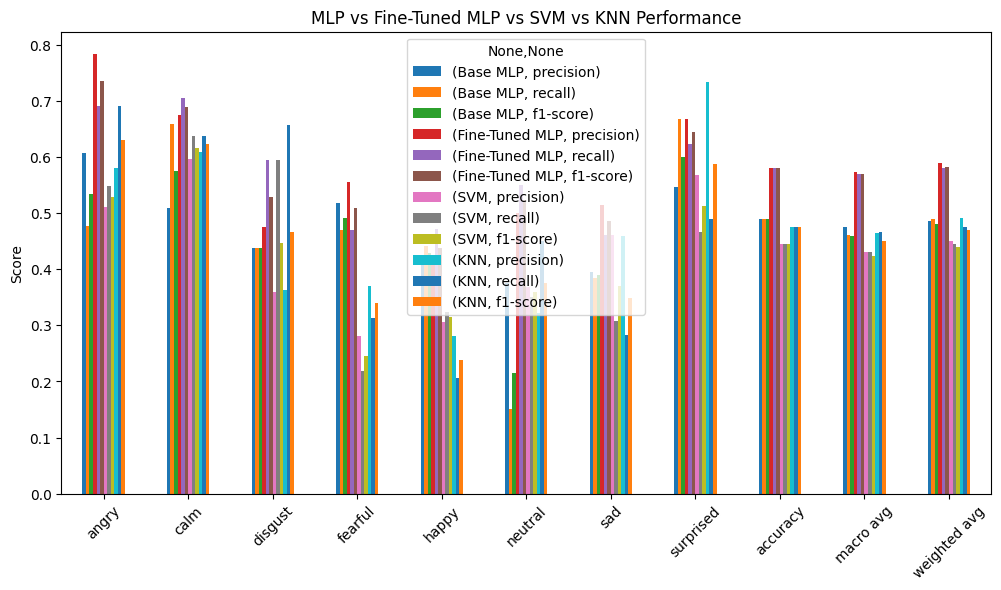

In [20]:
# Convert SVM and KNN classification reports into pandas dataframes
report_svm = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, output_dict=True)
report_knn = classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_, output_dict=True)

# Convert to pandas dataframe for comparison
df_svm = pd.DataFrame(report_svm).transpose()
df_knn = pd.DataFrame(report_knn).transpose()

# Concatenate for easy comparison
df_comparison_svm_knn = pd.concat([df_base[['precision', 'recall', 'f1-score']], 
                                   df_fine_tuned[['precision', 'recall', 'f1-score']],
                                   df_svm[['precision', 'recall', 'f1-score']], 
                                   df_knn[['precision', 'recall', 'f1-score']]],
                                  axis=1, keys=['Base MLP', 'Fine-Tuned MLP', 'SVM', 'KNN'])

# Show the comparison
print(df_comparison_svm_knn)

# Visualize the results
df_comparison_svm_knn.plot(kind='bar', figsize=(12,6))
plt.title('MLP vs Fine-Tuned MLP vs SVM vs KNN Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
